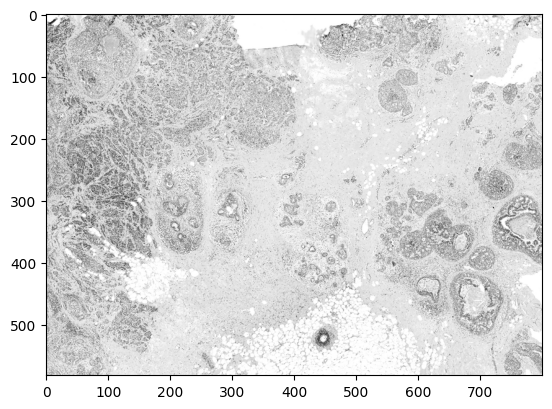

In [1]:
import json
import openslide
import javabridge
import bioformats
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from scipy.spatial import distance


data_path = "/mnt/c/Users/demeter_turos/PycharmProjects/chrysalis/data/xenium_human_breast_cancer/"

# hires slide scan
img_name = "Xenium_FFPE_Human_Breast_Cancer_Rep1_he_image_registered.ome.tif"

source = openslide.OpenSlide(data_path + img_name)

# look at the image
thumbnail = source.get_thumbnail((800, 800))
plt.imshow(thumbnail)
plt.show()

# apparently the channel/time axis is messed up in the metadata (hence grayscale) and I thought it's
# just easier to use something rather than rewriting it (openslide can't extract data stored along the
# time axis) so I'm using bioformats to get the image tiles

javabridge.start_vm(class_path=bioformats.JARS)

# this is so that javabridge doesn't spill out a lot of DEBUG messages during runtime
rootLoggerName = javabridge.get_static_field("org/slf4j/Logger", "ROOT_LOGGER_NAME", "Ljava/lang/String;")
rootLogger = javabridge.static_call("org/slf4j/LoggerFactory", "getLogger", "(Ljava/lang/String;)Lorg/slf4j/Logger;", rootLoggerName)
logLevel = javabridge.get_static_field("ch/qos/logback/classic/Level", "WARN", "Lch/qos/logback/classic/Level;")
javabridge.call(rootLogger, "setLevel", "(Lch/qos/logback/classic/Level;)V", logLevel)

# open file with bioformats
reader = bioformats.ImageReader(data_path + img_name)


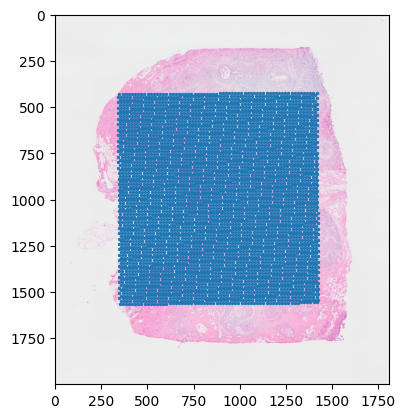

In [6]:
# visium data
# read xy coords
spot_df = pd.read_csv(data_path + 'visium/spatial/tissue_positions_list.csv', index_col=0, header=None)

# read scale factors from the spatial folder
with open(data_path + 'visium/spatial/scalefactors_json.json') as json_file:
    scale_factors = json.load(json_file)

# just to have the image displayed with the spots in the original coordiante system
im = Image.open(data_path + 'visium/spatial/tissue_hires_image.tif')

spot_df[4] = spot_df[4] * scale_factors['tissue_hires_scalef']
spot_df[5] = spot_df[5] * scale_factors['tissue_hires_scalef']
spot_df[[4, 5]] = spot_df[[5, 4]]

plt.scatter(x=spot_df[4], y=spot_df[5], s=2)
plt.imshow(im)
plt.show()


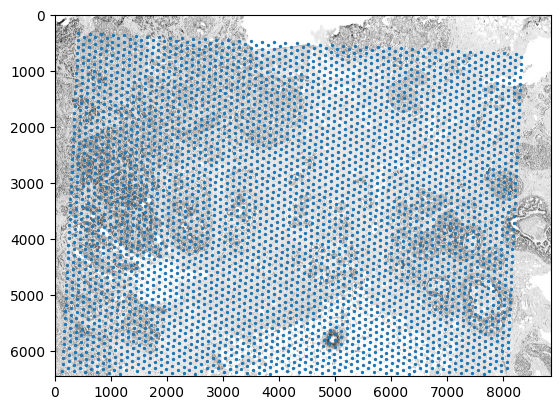

In [7]:
def transform_coordinates(coords, transform_matrix):
    # add a column of ones to the coordinates to allow for the translation step
    coords = np.hstack((coords, np.ones((len(coords), 1))))
    # multiply the coordinates by the matrix
    transformed_coords = np.dot(transform_matrix, coords.T).T
    # divide by the last element of each row to account for the translation
    transformed_coords = transformed_coords[:, :2] / transformed_coords[:, 2:]
    return transformed_coords


# read rotation matrices - in loupe browser a cytassist image is always required for co-registration,
# so we need to do visium -> cytassit and cytassist -> xenium

with open(data_path + 'cytassist_alignment_vistocyt.json') as json_file:
    alignment_json = json.load(json_file)
vtc_trm = np.array(alignment_json['cytAssistInfo']['transformImages'])

with open(data_path + 'cytassist_alignment_xetocyt.json') as json_file:
    alignment_json = json.load(json_file)
xtc_trm = np.array(alignment_json['cytAssistInfo']['transformImages'])

# transform visium coordinate system to cytassist
coords = spot_df[[4, 5]].values
coords_t = transform_coordinates(coords, vtc_trm)

# transform cytassist coordinate system to xenium - need the inverse of the original rot. matrix
coords_tt = transform_coordinates(coords_t, np.linalg.inv(xtc_trm))
spot_df[[4, 5]] = coords_tt

# (8854, 6444) is the resolution of the level 2 image in the ome.tiff but openslide doesn't see it for some reason
img = source.get_thumbnail((8854, 6444))

# we also need to calculate the spot diameter
spot_size = scale_factors['spot_diameter_fullres'] * scale_factors['tissue_hires_scalef']
spot_coords = np.array([[0, 0], [spot_size, 0]])
spot_coords = transform_coordinates(spot_coords, vtc_trm)
spot_coords = transform_coordinates(spot_coords, np.linalg.inv(xtc_trm))
dst = distance.euclidean(spot_coords[0], spot_coords[1])

# subset spots because we don't have 1:1 overlap
spot_df = spot_df[spot_df[5] <= 6444 - dst / 2]

plt.imshow(img)
plt.scatter(x=spot_df[4], y=spot_df[5], s=2)
plt.show()


In [8]:
# scale factor between level 2 and 0
sf = 4
dst_orig = int(dst * sf)

# collect spots
spot_pos = spot_df[[4, 5]].values
spot_array = np.empty((len(spot_df), 299, 299, 3)).astype(int)
to_remove = []

for idx, xy in tqdm(enumerate(spot_pos), total=len(spot_df)):
    spot_start = (int((xy[0]) - dst_orig / 2),
                  int((xy[1]) - dst_orig / 2))

    # spot = source.read_region(location=spot_start, level=0, size=(dst_orig, dst_orig))

    spot = np.zeros([dst_orig, dst_orig, 3])

    x_min = int((xy[0]) - dst_orig / 2)
    y_min = int((xy[1]) - dst_orig / 2)

    xdiff = 0
    ydiff = 0

    # quick fix for some negative values due to some rounding errors
    # for spots that are very close to the edge of the image
    if 0 > x_min:
        x_min = 0
        xdiff = -1 * x_min
        to_remove.append(idx)
    elif 0 > y_min:
        y_min = 0
        ydiff = -1 * y_min
        to_remove.append(idx)

    # read RGB channels separately from the time axes
    for i in range(3):
        spot[xdiff:, ydiff:, i] = reader.read(t=i, rescale=False, XYWH=(x_min, y_min, dst_orig, dst_orig))

    spot = Image.fromarray(np.uint8(spot)).convert('RGB')
    spot = spot.resize((299, 299))
    spot = np.array(spot)[:, :, :3]
    spot_array[idx, :, :, :] = spot

# remove the overhanging tiles
# spot_array = np.delete(spot_array, to_remove, 0)
to_keep = set(range(len(spot_array))).difference(set(to_remove))
spot_array = spot_array[tuple(to_keep), :, :, :]
# remove rows from the dataframe
spot_df = spot_df.drop(spot_df.index[to_remove])


100%|██████████| 3912/3912 [01:08<00:00, 57.10it/s]


In [11]:
np.save(data_path + 'tiles_299.npy', spot_array)
spot_df.to_csv(data_path + 'tiles_299_data.csv')


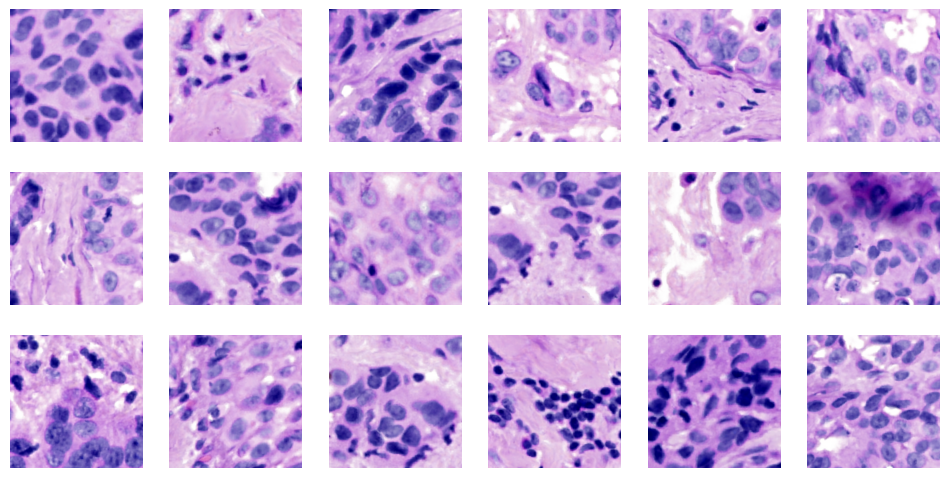

In [12]:
# look at same patches
fig, ax = plt.subplots(3, 6, figsize=(12, 6))
ax = ax.flatten()
for a in ax:
    p = np.random.randint(0, len(spot_array), 1)[0]
    a.imshow(spot_array[p, :, :, :])
    a.axis('off')
plt.show()